# JupySQL DuckDB


## Resources

- [JupySQL](https://jupysql.ploomber.io/en/latest/quick-start.html)

- [DuckDB](https://duckdb.org/docs/archive/0.8.1/guides/python/jupyter)


## Setup


In [1]:
# %pip install jupysql duckdb-engine duckdb --quiet

In [2]:
import duckdb
import pandas as pd

# Enable create sql cells
%load_ext sql

In [32]:
%config SqlMagic.autopandas=True
%config SqlMagic.feedback=False
%config SqlMagic.displaycon=False
%config SqlMagic.named_parameters=True

In [4]:
%sql duckdb:///:default:

## Querying


In [5]:
%sql SELECT 'Off and flying!' as duckdb_column

,duckdb_column
0,Off and flying!


In [6]:
%%sql
SELECT
    schema_name,
    function_name,
FROM duckdb_functions()
ORDER BY ALL DESC
LIMIT 5


,schema_name,function_name
0,pg_catalog,shobj_description
1,pg_catalog,shobj_description
2,pg_catalog,shobj_description
3,pg_catalog,pg_typeof
4,pg_catalog,pg_typeof


In [7]:
%sql some_df << SELECT 'Off and flying!' as duckdb_column

In [8]:
some_df.head()

,duckdb_column
0,Off and flying!


In [9]:
input_df = pd.DataFrame.from_dict(
    {"i": [1, 2, 3], "j": ["one", "two", "three"]}
)

In [10]:
%sql SELECT sum(i) as total_i FROM input_df

,total_i
0,6.0


In [11]:
%%sql
INSTALL httpfs;
LOAD httpfs;

,Success


<Axes: title={'center': "'trip_distance' from 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet'"}, ylabel='trip_distance'>

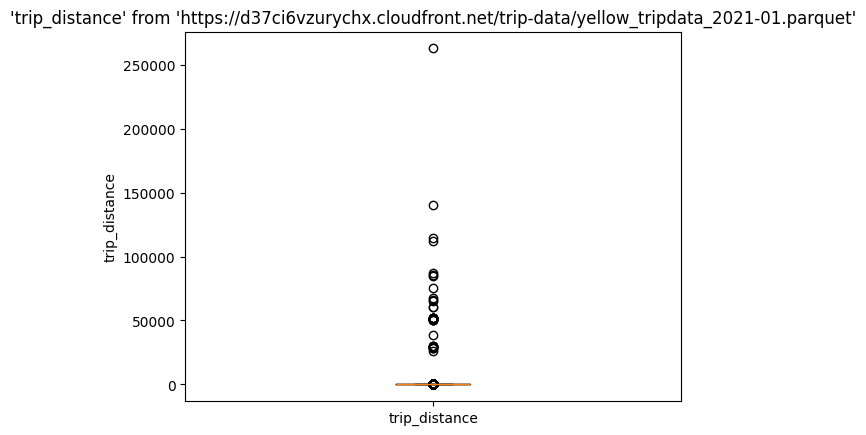

In [12]:
%sqlplot boxplot --table https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet --column trip_distance

In [13]:
%%sql --save short_trips --no-execute
SELECT *
FROM "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"
WHERE trip_distance < 6.3

Skipping execution...

In [14]:
%sql SELECT * FROM short_trips LIMIT 5

Generating CTE with stored snippets: 'short_trips'

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN
3,1,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.60,1.0,N,224,68,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5,NaN
4,1,2021-01-01 00:00:28,2021-01-01 00:17:28,1.0,4.10,1.0,N,95,157,2,16.0,0.5,0.5,0.00,0.0,0.3,17.30,0.0,NaN


<Axes: title={'center': "'trip_distance' from 'short_trips'"}, xlabel='trip_distance', ylabel='Count'>

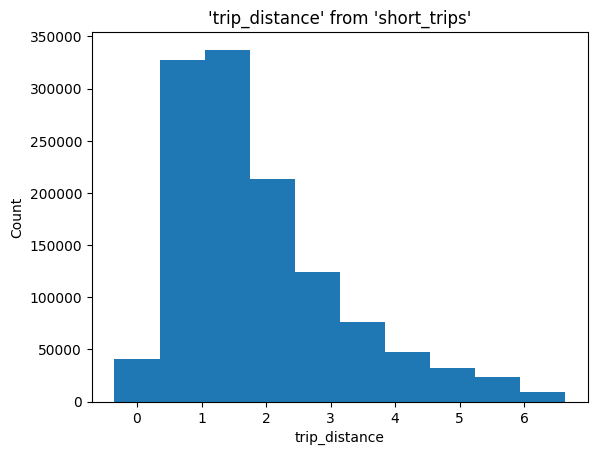

In [15]:
%sqlplot histogram --table short_trips --column trip_distance --bins 10 --with short_trips

## Nested Json column


In [38]:
%%sql
CREATE OR REPLACE TABLE people(
    id INTEGER,
    name VARCHAR,
    age INTEGER,
    addresses JSON[]
);

INSERT INTO people VALUES
(1, 'John', 30, '[{"street":"123 Main St","city":"New York","state":"NY"},{"street":"456 Elm St","city":"Los Angeles","state":"CA"}]'),
(2, 'Alice', 25, '[{"street":"789 Oak St","city":"Chicago","state":"IL"}]'),
(3, 'Bob', 35, '[{"street":"101 Pine St","city":"San Francisco","state":"CA"},{"street":"202 Cedar St","city":"Seattle","state":"WA"}]');


,Success


In [39]:
%sql SELECT * FROM people

,id,name,age,addresses
0,1,John,30,"[{""street"":""123 Main St"",""city"":""New York"",""st..."
1,2,Alice,25,"[{""street"":""789 Oak St"",""city"":""Chicago"",""stat..."
2,3,Bob,35,"[{""street"":""101 Pine St"",""city"":""San Francisco..."


In [86]:
%%sql
SELECT
    id,
    name,
    age,
    json_extract(address.addresses::JSON, '$.street') AS street,
    json_extract(address.addresses::JSON, '$.city') AS city,
    json_extract(address.addresses::JSON, '$.state') AS state,

    address.addresses::JSON->>'$.street' AS street,
    address.addresses::JSON->>'$.city' AS city,
    address.addresses::JSON->>'$.state' AS state

FROM people,
    UNNEST(addresses) AS address;

,id,name,age,street,city,state,street_2,city_2,state_2
0,1,John,30,"""456 Elm St""","""Los Angeles""","""CA""",456 Elm St,Los Angeles,CA
1,2,Alice,25,"""789 Oak St""","""Chicago""","""IL""",789 Oak St,Chicago,IL
2,3,Bob,35,"""202 Cedar St""","""Seattle""","""WA""",202 Cedar St,Seattle,WA
3,1,John,30,"""123 Main St""","""New York""","""NY""",123 Main St,New York,NY
4,3,Bob,35,"""101 Pine St""","""San Francisco""","""CA""",101 Pine St,San Francisco,CA


## Subquery


In [89]:
%%sql
CREATE OR REPLACE TABLE students (
    student_id INT PRIMARY KEY,
    student_name VARCHAR(50)
);


CREATE OR REPLACE TABLE grades (
    student_id INT,
    subject VARCHAR(50),
    grade INT
);


INSERT INTO students (student_id, student_name) VALUES
    (1, 'John'),
    (2, 'Alice'),
    (3, 'Bob');

INSERT INTO grades (student_id, subject, grade) VALUES
    (1, 'Math', 90),
    (1, 'Science', 85),
    (2, 'Math', 88),
    (2, 'Science', 92),
    (3, 'Math', 78),
    (3, 'Science', 80);

,Success


In [95]:
%%sql
SELECT student_name
FROM students
WHERE student_id IN (
    SELECT student_id
    FROM grades
    WHERE subject = 'Math' AND grade > 85
);

,student_name
0,John
1,Alice


In [96]:
%%sql
SELECT AVG(subquery.grade) AS average_math_grade
FROM (
    SELECT grade
    FROM grades
    WHERE subject = 'Math' AND grade > 85
) AS subquery;

,average_math_grade
0,89.0
